<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-4--job-resume-improvement/02_matrix_data_dimension_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dimension reduction of matrix data

Dimension reduction is a series of techniques for shrinking data while retaining its
information content. These techniques permeate many of our everyday digital
activities.

These are the following advantages of dimensionally reduced data:
* More compact data is easier to transfer and store.
* Algorithmic tasks require less time when our data is smaller.
* Certain complex tasks, like cluster detection, can be simplified by removing
unnecessary information.

We want to cluster thousands
of text documents by topic. The clustering will entail computing a matrix of all-by-all document similarities.

As we know, this computation can be slow. Dimension reduction can speed up the process by reducing the number
of data matrix columns. 

As a further bonus, dimensionally reduced text data has been
shown to yield higher-quality topic clusters.

##Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
from collections import defaultdict
from collections import Counter
import time
import numpy as np
import pandas as pd
from math import sin, cos

from sklearn.decomposition import PCA

from scipy.spatial.distance import euclidean
from numpy.linalg import norm

import seaborn as sns
import matplotlib.pyplot as plt

##Clustering 2D data in one dimension

Dimension reduction has many uses, including more interpretable clustering.

Let’s start by simulating customer heights. Our heights range from
60 inches (5 ft) to 78 inches (6.5 ft). We fabricate these heights by calling
np.arange(60, 78, 0.1). 

This returns an array of heights between 60 and 78 inches,
where each consecutive height increases by 0.1 inches.

In [3]:
# Simulating a range of heights
heights = np.arange(60, 78, 0.1)

It has been shown that, on average, a person’s
weight in pounds equals approximately `4 * height - 130`. 

Of course, each individual
person’s weight fluctuates around this average value.

In [4]:
# Simulating weights using heights
np.random.seed(0)

random_fluctuations = np.random.normal(scale=10, size=heights.size)
weights = 4 * heights - 130 + random_fluctuations

Let’s store and plot these measured coordinates.

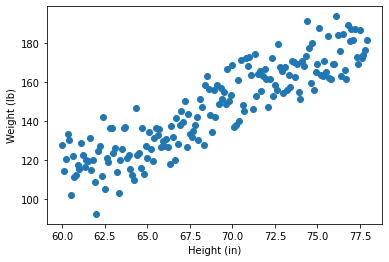

In [5]:
measurements = np.array([heights, weights])

plt.scatter(measurements[0], measurements[1])
plt.xlabel("Height (in)")
plt.ylabel("Weight (lb)")
plt.show()

As a reminder, Matplotlib manipulates its 2D axes to make the final plot aesthetically pleasing. Normally, this is a good thing. 

However, we’ll soon be rotating the plot to simplify our data. The rotation
will shift the axes scaling, making the rotated data difficult to compare with the original data plot. 

Consequently, we should equalize our axes to obtain consistent visual
output.

Let’s equalize the axes and hen regenerate the plot.

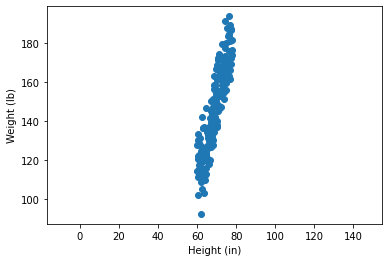

In [6]:
# Plotting 2D measurements using equally scaled axes
plt.scatter(measurements[0], measurements[1])
plt.xlabel("Height (in)")
plt.ylabel("Weight (lb)")
plt.axis("equal")
plt.show()

If we rotate our data toward the x-axis, the horizontal x-values should be sufficient to
distinguish between points. We can thus cluster the data without relying on the vertical y-values. 

Effectively, we’ll be able to delete the y-values with minimal information loss.
That deletion will reduce our data from two dimensions to one.

###Reducing dimensions using rotation

Centering our data at the origin is trivial. The central point of every dataset is equal to
its mean. 

Thus, we need to adjust our coordinates so that their x-value mean and y-value
mean both equal zero.

Let’s shift our height and weight coordinates and store these changes in a `centered_data` array. Then we plot the shifted coordinates to verify that they are centered on the origin.

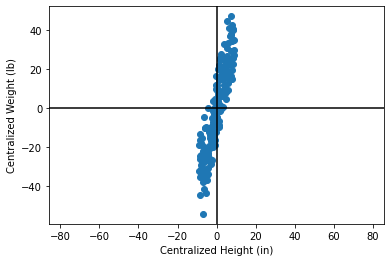

In [7]:
# Centering the measurements at the origin
centered_data = np.array([heights - heights.mean(), weights - weights.mean()])

plt.scatter(centered_data[0], centered_data[1])
# Visualizes the x-axis and y-axis to mark the location of the origin
plt.axhline(0, c="black")
plt.axvline(0, c="black")
plt.xlabel("Centralized Height (in)")
plt.ylabel("Centralized Weight (lb)")
plt.axis("equal")
plt.show()

Our data is now perfectly centered at the origin. However, the orientation of the data
is closer to the y-axis than the x-axis. Our goal is to adjust this orientation through
rotation. 

We want to spin the plotted points around the origin until they overlap with
the x-axis. Rotating a 2D plot around its center requires the use of a rotation matrix.

Let’s utilize the rotation matrix to rotate `centered_data` clockwise by 90 degrees.

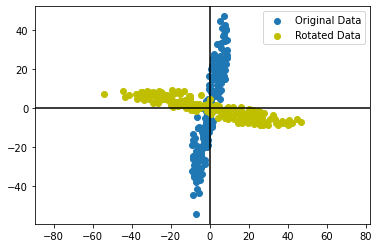

In [8]:
# Rotating centered_data by 90 degrees
angle = np.radians(-90)
rotation_matrix = np.array([
  [cos(angle), -sin(angle)],
  [sin(angle), cos(angle)]                         
])

rotated_data = rotation_matrix @ centered_data

plt.scatter(centered_data[0], centered_data[1], label="Original Data")
plt.scatter(rotated_data[0], rotated_data[1], c="y", label="Rotated Data")
plt.axhline(0, c="black")
plt.axvline(0, c="black")
plt.legend()
plt.axis("equal")
plt.show()

Our rotation has shifted
the plot closer to the x-axis. We need a way to quantify this shift. Let’s generate a penalty
score that decreases as the data is rotated toward the x-axis.

We’ll penalize all vertical y-axis values. Our penalty is based on the concept of
squared distance.

In [9]:
# Penalizing vertical y-values
data_labels = ["unrotated", "rotated"]
data_list = [centered_data, rotated_data]

for data_label, data in zip(data_labels, data_list):
  y_values = data[1]
  penalty = y_values @ y_values / y_values.size
  print(f"The penalty score for the {data_label} data is {penalty:.2f}")

The penalty score for the unrotated data is 519.82
The penalty score for the rotated data is 27.00


Rotating the data has reduced the penalty score by more than 20-fold. This reduction
carries a statistical interpretation.

We’ve inferred that the penalty score equals the y-axis variance.

Consequently, our
data rotation has reduced the y-axis variance by more than 20-fold. 

Let’s confirm.

In [10]:
# Equating penalties with y-axis variance
for data_label, data in zip(data_labels, data_list):
  y_var = data[1].var()
  penalty = data[1] @ data[1] / data[0].size
  assert round(y_var, 14) == round(penalty, 14)
  print(f"The y-axis variance for the {data_label} data is {y_var:.2f}")

The y-axis variance for the unrotated data is 519.82
The y-axis variance for the rotated data is 27.00


We can score rotations based on variance. Rotating the data toward the x-axis reduces
the variance along the y-axis. 

How does this rotation influence the variance along the
x-axis? 

Let’s find out.

In [11]:
# Measuring rotational x-axis variance
for data_label, data in zip(data_labels, data_list):
  x_var = data[0].var()
  print(f"The x-axis variance for the {data_label} data is {x_var:.2f}")

The x-axis variance for the unrotated data is 27.00
The x-axis variance for the rotated data is 519.82


The rotation has completely flipped the x-axis variance and the y-axis variance. 

However, the total sum of variance values has remained unchanged. Total variance is conserved
even after the rotation. 

Let’s verify this fact.

In [12]:
# Confirming the conservation of total variance
total_variance = centered_data[0].var() + centered_data[1].var()
assert total_variance == rotated_data[0].var() + rotated_data[1].var()

Conservation of variance allows us to infer the following:

* x-axis variance and y-axis variance can be combined into a single percentage
score.
* Decreasing the vertical dispersion
by p percent increases the horizontal dispersion by p percent.

Let's confirms these conclusions.

In [13]:
# Exploring the percent coverage of axis variance
for data_label, data in zip(data_labels, data_list):
  percent_x_axis_var = 100 * data[0].var() / total_variance
  percent_y_axis_var = 100 * data[1].var() / total_variance
  print(f"In the {data_label} data, {percent_x_axis_var:.2f} of the total variance is distributed across the x-axis")
  print(f"The remaining {percent_y_axis_var:.2f} of the total variance is distributed across the y-axis")

In the unrotated data, 4.94 of the total variance is distributed across the x-axis
The remaining 95.06 of the total variance is distributed across the y-axis
In the rotated data, 95.06 of the total variance is distributed across the x-axis
The remaining 4.94 of the total variance is distributed across the y-axis


Rotating the data toward the x-axis has increased the x-axis variance by 90 percentage
points. 

Simultaneously, the rotation has reduced the y-axis variance by these same 90
percentage points.

Let’s rotate centered_data even further until its distance to the x-axis is minimized.

In [14]:
# Maximizing horizontal dispersion
def rotate(angle, data=centered_data):
  angle = np.radians(-angle)
  rotation_matrix = np.array([
    [cos(angle), -sin(angle)],
    [sin(angle), cos(angle)]                            
  ])
  return rotation_matrix @ data

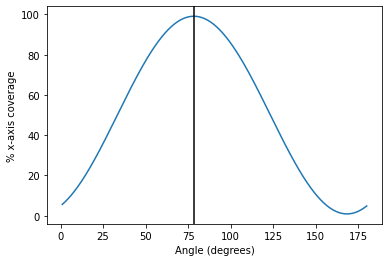

The horizontal variance is maximized to approximately 541 after a 78.3 degree rotation.
That rotation distributes 99.08 of the total variance onto the x-axis.


In [15]:
# Returns an array of angles ranging from 0 to 180, where each consecutive angle increases by 0.1 degrees
angles = np.arange(1, 180, 0.1)
# Computes the x-axis variance for each rotation across every angle
x_variances = [(rotate(angle)[0].var()) for angle in angles]

# Computes the angle of rotation resulting in the maximum variance
percent_x_variances = 100 * np.array(x_variances) / total_variance
optimal_index = np.argmax(percent_x_variances)
optimal_angle = angles[optimal_index]

plt.plot(angles, percent_x_variances)
plt.axvline(optimal_angle, c="black")
plt.xlabel("Angle (degrees)")
plt.ylabel("% x-axis coverage")
plt.show()

max_coverage = percent_x_variances[optimal_index]
max_x_var = x_variances[optimal_index]

print(f"The horizontal variance is maximized to approximately {int(max_x_var)} after a {optimal_angle:.1f} degree rotation.")
print(f"That rotation distributes {max_coverage:.2f} of the total variance onto the x-axis.")

Thus, we can expect the rotated data to mostly lie along the 1D axis line.

Let’s confirm
by running the rotation and then plotting the results.

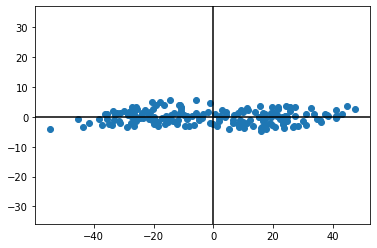

In [16]:
# Plotting rotated data with high x-axis coverage
best_rotated_data = rotate(optimal_angle)

plt.scatter(best_rotated_data[0], best_rotated_data[1])
plt.axhline(0, c="black")
plt.axvline(0, c="black")
plt.axis("equal")
plt.show()

Most of the data lies close to the x-axis. The data’s dispersion is maximized in that horizontal
direction.

Consequently, we can delete all y-axis coordinates with minimal information
loss. That deletion should account for less than 1% of the total variance, so the
remaining x-axis values will be sufficient to cluster our measurements.

Let’s reduce best_rotated_data to 1D by disposing of the y-axis. Then we’ll use the remaining 1D array to extract two clustering thresholds.

In [17]:
# Reducing the rotated data to 1D for the purposes of clustering
x_values = best_rotated_data[0]
sorted_x_values = sorted(x_values)
cluster_size = int(x_values.size / 3)
small_cutoff = max(sorted_x_values[:cluster_size])
large_cutoff = min(sorted_x_values[-cluster_size:])

print(f"A 1D threshold of {small_cutoff:.2f} separates the small-sized and medium-sized customers.")
print(f"A 1D threshold of {large_cutoff:.2f} separates the medium-sized and large-sized customers.")

A 1D threshold of -14.61 separates the small-sized and medium-sized customers.
A 1D threshold of 15.80 separates the medium-sized and large-sized customers.


We can visualize our thresholds by utilizing them to vertically slice our `best_reduced_data` plot.

In [18]:
# Plotting horizontal customer data separated into three segments
def plot_customer_segments(horizontal_2d_data):
  small, medium, large = [], [], []
  cluster_labels = ["Small", "Medium", "Large"]
  # 1D x-value thresholds are utilized to segment the data
  for x_value, y_value in horizontal_2d_data.T:
    if x_value <= small_cutoff:
      small.append([x_value, y_value])
    elif small_cutoff < x_value < large_cutoff:
      medium.append([x_value, y_value])
    else:
      large.append([x_value, y_value])

  # Each customer segment is plotted separately
  for i, cluster in enumerate([small, medium, large]):
    cluster_x_values, cluster_y_values = np.array(cluster).T
    plt.scatter(cluster_x_values, cluster_y_values, color=["g", "b", "y"][i], label=cluster_labels[i])

  plt.axhline(0, c="black")
  plt.axvline(large_cutoff, c="black", linewidth=3, linestyle="--")
  plt.axvline(small_cutoff, c="black", linewidth=3, linestyle="--")
  plt.axis("equal")
  plt.legend()
  plt.show()

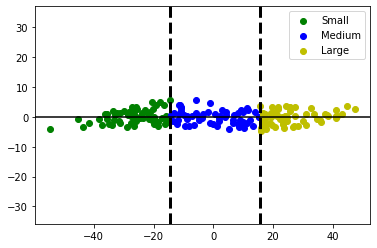

In [19]:
plot_customer_segments(best_rotated_data)

Our 1D `x_values` array can sufficiently segment the customer data because it captures `99.08%` of the data’s variance. 

Consequently, we can use the array to reproduce
`99.08%` of our centered_data dataset.

In [20]:
# Reproducing 2D data from a 1D array
zero_y_values = np.zeros(x_values.size)
reproduced_data = rotate(-optimal_angle, data=[x_values, zero_y_values])

Let’s plot `reproduced_data` together with our `centered_data` matrix to gauge the quality of the reproduction.

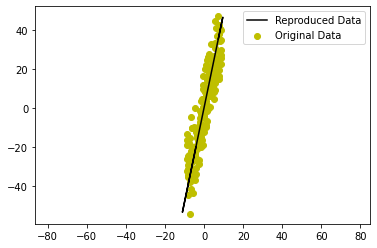

In [21]:
# Plotting reproduced and original data
plt.plot(reproduced_data[0], reproduced_data[1], c="k", label="Reproduced Data")
plt.scatter(centered_data[0], centered_data[1], c="y", label="Original Data")
plt.axis("equal")
plt.legend()
plt.show()

The reproduced data forms a line that cuts directly through the middle of the
centered_data scatter plot. 

The line represents the first principal direction, which is the
linear direction in which the data’s variance is maximized. 

Most 2D datasets contain
two principal directions. 

The second principal direction is perpendicular to the first; it
represents the remaining variance not covered by the first direction.

We can use the first principal direction to process the heights and weights of future customers.

Let’s explore this scenario more concretely by simulating new customer measurements.

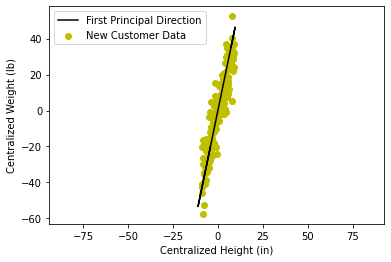

In [22]:
# Simulating and plotting new customer data
np.random.seed(1)

# Separates all new heights by 0.11 inches to minimize overlap with previous heights
new_heights = np.arange(60, 78, .11)
random_fluctuations = np.random.normal(scale=10, size=new_heights.size)
new_weights = 4 * new_heights - 130 + random_fluctuations

# We assume that the new customer distribution is the same as the previously seen distribution
# This allows us to utilize existing means for data centralization
new_centered_data = np.array([new_heights - heights.mean(), new_weights - weights.mean()])

plt.scatter(new_centered_data[0], new_centered_data[1], c="y", label="New Customer Data")
plt.plot(reproduced_data[0], reproduced_data[1], c="k", label="First Principal Direction")
plt.xlabel("Centralized Height (in)")
plt.ylabel("Centralized Weight (lb)")
plt.axis("equal")
plt.legend()
plt.show()

Our new customer data continues to lie along the first principal direction. That direction
covers more than 99% of the data variance while also forming a 78.3-degree angle
with the x-axis.

Next, we position our new customer data horizontally and segment that data.

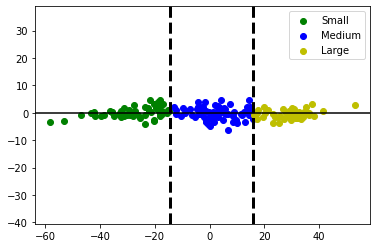

In [23]:
# Rotating and segmenting our new customer data
new_horizontal_data = rotate(optimal_angle, data=new_centered_data)
plot_customer_segments(new_horizontal_data)

So, it’s easier to flip the data when we
know the principal direction along which the variance is maximized. Given the first principal direction, we dimensionally reduce customer data for easier clustering.

Unfortunately, this technique does not scale to higher dimensions.

Imagine if we analyze a 1,000-dimensional dataset; checking every angle across 1,000
different axes is not computationally feasible.

Fortunately, there’s an easier way to
extract all principal directions. We just need to apply a scalable algorithm known as principal component analysis (PCA).

##Dimension reduction using PCA

The PCA algorithm adjusts a dataset’s axes so that most of the variance is spread
across a small number of dimensions. 

Consequently, not every dimension is required
to distinguish between the data points. Simplified data distinction leads to simplified
clustering.

In [25]:
# Initializing a pca_model object
pca_model = PCA()

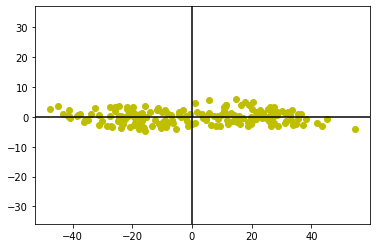

In [26]:
# Running PCA using scikit-learn
pca_transformed_data = pca_model.fit_transform(measurements.T)

plt.scatter(pca_transformed_data[:, 0], pca_transformed_data[:, 1], c="y", label="New Customer Data")
plt.axhline(0, c="black")
plt.axvline(0, c="black")
plt.axis("equal")
plt.show()

Running PCA on a 2D dataset is guaranteed to tip over that data so it lies horizontally on
the x-axis. 

However, the actual reflection of data is not restricted to one particular orientation.

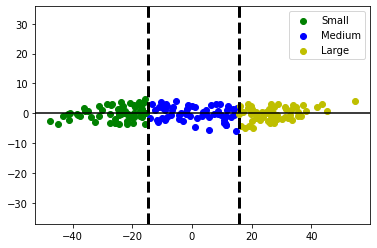

In [27]:
# re-create our original horizontal plot
plot_customer_segments((pca_transformed_data * np.array([1, -1])).T)

Even though our plotted data is oriented differently, its x-axis variance coverage should remain consistent with our previous observations. 

We can confirm using the `explained_variance_ratio_` attribute of `pca_object`.

In [28]:
# Extracting variance from scikit-learn’s PCA output
percent_variance_coverages = 100 * pca_model.explained_variance_ratio_   # Multiplying by 100 converts these fractions into percentages
x_axis_coverage, y_axis_coverage = percent_variance_coverages
print(f"The x-axis of our PCA output covers {x_axis_coverage:.2f}% of the total variance")

The x-axis of our PCA output covers 99.08% of the total variance


As a reminder, vectors are linear segments that
point in a certain direction from the origin. 

Also, the first principal direction is a line
that rises from the origin. 

Consequently, we can represent the first principal direction
as a vector called the first principal component.

In [30]:
# Outputting the first principal component
first_pc = pca_model.components_[0]
magnitude = norm(first_pc)

print(f"Vector {first_pc} points in a direction that covers {x_axis_coverage:.2f}% of the total variance.")
print(f"The vector has a magnitude of {magnitude}")

Vector [-0.20223994 -0.979336  ] points in a direction that covers 99.08% of the total variance.
The vector has a magnitude of 1.0


The first principal component is a unit vector with a magnitude of 1.0. It stretches one
whole unit length from the origin. 

Multiplying the vector by a number stretches the
magnitude out further. 

If we stretch it far enough, we can capture the entire principal
direction of our data.

First, we stretch our `first_pc` vector until
it extends 50 units in both the positive and negative directions from the origin. 

We then plot the stretched segment along with our previously computed `centered_data`
matrix.

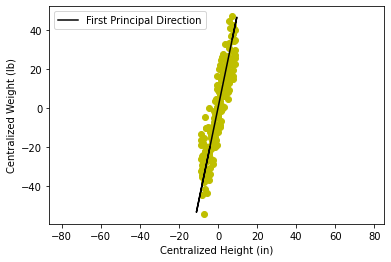

In [31]:
# Stretching a unit vector to cover the first principal direction
def plot_stretched_vector(v, **kwargs):
  # extends 50 units in both the positive and negative directions from the origin
  plt.plot([-50 * v[0], 50 * v[0]], [-50 * v[1], 50 * v[1]], **kwargs)

plt.plot(reproduced_data[0], reproduced_data[1], c="k", label="First Principal Direction")
plt.scatter(centered_data[0], centered_data[1], c="y")
plt.xlabel("Centralized Height (in)")
plt.ylabel("Centralized Weight (lb)")
plt.axis("equal")
plt.legend()
plt.show()

We’ve used the first principal component to skewer our dataset along its first principal
direction. 

In that same manner, we can stretch the other directional unit vector
returned by the PCA algorithm.

As we know, most 2D datasets contain two principal
directions. 

The second principal direction is perpendicular to the first, and its vectorized representation is called the second principal component. That component is
stored in the second row of our computed components matrix.